In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=195c1b6e804956b14f29c5cdf8e8c92eb5fae256204419ed6634a35549967a6f
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 1. Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/DGA/RNN/dataset_all.csv')
df

,Unnamed: 0,domain,class
0,0,google.com,legit
1,1,facebook.com,legit
2,2,youtube.com,legit
3,3,baidu.com,legit
4,4,yahoo.com,legit
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


In [ ]:
# Lọc ra lớp 'legit'
filtered_df = df[df['class'] != 'legit']
filtered_df

,Unnamed: 0,domain,class
1000000,1000000,uhbqolxf.org,conficker
1000001,1000001,gzhwfdwnjrg.cc,conficker
1000002,1000002,oyxiufvc.ws,conficker
1000003,1000003,ufaqzt.cn,conficker
1000004,1000004,cejzf.org,conficker
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


# 2. Normalize dữ liệu

## 2.1. Mã hóa nhãn

In [ ]:
# Trộn dữ liệu trước khi mã hóa nhãn
shuffled_data = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Định nghĩa một từ điển ánh xạ tùy chỉnh để đảm bảo thứ tự mong muốn mà không có lớp 'legit'
custom_mapping = {
    'conficker': 0,
    'cryptolocker': 1,
    'zeus': 2,
    'pushdo': 3,
    'rovnix': 4,
    'tinba': 5,
    'matsnu': 6,
    'ramdo': 7
}

# Các lớp duy nhất trước khi mã hóa nhãn
unique_classes_before_encoding = shuffled_data['class'].unique()
print("Unique classes before label encoding:", unique_classes_before_encoding)

# Áp dụng mã hóa nhãn bằng cách sử dụng ánh xạ tùy chỉnh
shuffled_data['class'] = shuffled_data['class'].map(custom_mapping)

# Mã hóa nhãn lớp
label_encoder = LabelEncoder()
shuffled_data['class'] = label_encoder.fit_transform(shuffled_data['class'])

# Các lớp duy nhất sau khi mã hóa nhãn
unique_classes_after_encoding = label_encoder.classes_
print("Unique classes after label encoding:", unique_classes_after_encoding)

# Định nghĩa một từ điển ánh xạ đảo ngược
reverse_mapping = {v: k for k, v in custom_mapping.items()}

# In ra số được gán cho mỗi lớp sau khi mã hóa nhãn
for class_number in unique_classes_after_encoding:
    class_name = reverse_mapping[class_number]
    print(f"Class: {class_name}, Encoded number: {class_number}")

Unique classes before label encoding: ['zeus' 'rovnix' 'tinba' 'cryptolocker' 'ramdo' 'pushdo' 'matsnu'
 'conficker']
Unique classes after label encoding: [0 1 2 3 4 5 6 7]
Class: conficker, Encoded number: 0
Class: cryptolocker, Encoded number: 1
Class: zeus, Encoded number: 2
Class: pushdo, Encoded number: 3
Class: rovnix, Encoded number: 4
Class: tinba, Encoded number: 5
Class: matsnu, Encoded number: 6
Class: ramdo, Encoded number: 7


## 2.2. Mã hóa tên miền

In [ ]:
# Mã hóa tên miền
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(shuffled_data['domain'])
encoded_domain = tokenizer.texts_to_sequences(shuffled_data['domain'])

# In dữ liệu đã mã hóa và nhãn lớp
encoded_data_with_labels = pd.DataFrame({'Encoded Domain': encoded_domain, 'Encoded Class': shuffled_data['class']})
print(encoded_data_with_labels)

# Lấp đầy các chuỗi để đảm bảo độ dài đồng nhất
max_sequence_length = max([len(seq) for seq in encoded_domain])
print("Max sequence length: " + str(max_sequence_length))
padded_domain = pad_sequences(encoded_domain, maxlen=max_sequence_length)

# Xác định kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because index 0 is reserved
print(f"Vocab size: {vocab_size}")

                                           Encoded Domain  Encoded Class
0       [25, 9, 9, 29, 5, 8, 23, 5, 25, 16, 18, 5, 29,...              2
1       [28, 18, 11, 14, 27, 30, 17, 7, 31, 10, 20, 11...              2
2       [21, 2, 1, 21, 14, 2, 9, 18, 8, 9, 2, 11, 9, 5...              4
3       [19, 9, 9, 1, 2, 22, 16, 3, 3, 18, 1, 1, 6, 3,...              5
4       [24, 7, 7, 11, 27, 14, 13, 17, 4, 26, 12, 20, ...              1
...                                                   ...            ...
799995  [25, 11, 20, 29, 37, 12, 12, 25, 24, 7, 32, 15...              2
799996              [13, 5, 3, 14, 5, 9, 5, 17, 6, 4, 12]              3
799997  [8, 24, 3, 14, 11, 18, 27, 11, 3, 16, 19, 16, ...              1
799998  [15, 12, 10, 9, 13, 12, 5, 15, 2, 23, 12, 2, 1...              6
799999  [11, 13, 24, 15, 8, 4, 23, 3, 20, 10, 23, 27, ...              1

[800000 rows x 2 columns]
Max sequence length: 40
Vocab size: 38


# 3. Xây dựng và huấn luyện model

## 3.1. Chia dữ liệu thành tập huấn luyện và kiếm tra

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(padded_domain, shuffled_data['class'], test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (640000, 40)
Shape of X_test: (160000, 40)
Shape of y_train: (640000,)
Shape of y_test: (160000,)


## 3.2. Xây dựng model

In [ ]:
# Chọn kích thước nhúng
embedding_dim = 64

# Định nghĩa kiến trúc mô hình
model = Sequential()

# Thêm lớp nhúng với kích thước đầu vào, kích thước đầu ra và độ dài đầu vào
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Thêm lớp LSTM đối xứng
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Thêm tự chú ý dãn dấu trình tự
model.add(SeqSelfAttention(attention_activation='sigmoid'))

# Thêm lớp dropout đầu tiên để tránh overfitting
model.add(Dropout(0.5))

# Thêm lớp LSTM đối xứng khác
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Thêm chú ý trọng số trình tự
model.add(SeqWeightedAttention())

# Thêm lớp kích hoạt ReLU
model.add(Dense(units=64, activation='relu'))

# Thêm lớp dropout thứ hai để tránh overfitting
model.add(Dropout(0.5))

# Thêm lớp kích hoạt softmax cho việc phân loại nhiều lớp
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tóm tắt mô hình
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            2432      
                                                                 
 bidirectional_2 (Bidirecti  (None, 40, 128)           66048     
 onal)                                                           
                                                                 
 seq_self_attention_1 (SeqS  (None, 40, 128)           8257      
 elfAttention)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 40, 128)           98816     
 onal)                                                           
                                                      

## 3.3. Huấn luyện mô hình

In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
5000/5000 [==============================] - 93s 16ms/step - loss: 0.1549 - accuracy: 0.9436 - val_loss: 0.0976 - val_accuracy: 0.9645
Epoch 2/10
5000/5000 [==============================] - 85s 17ms/step - loss: 0.0688 - accuracy: 0.9761 - val_loss: 0.0751 - val_accuracy: 0.9758
Epoch 3/10
5000/5000 [==============================] - 83s 17ms/step - loss: 0.0354 - accuracy: 0.9896 - val_loss: 0.0285 - val_accuracy: 0.9916
Epoch 4/10
5000/5000 [==============================] - 79s 16ms/step - loss: 0.0230 - accuracy: 0.9941 - val_loss: 0.0169 - val_accuracy: 0.9959
Epoch 5/10
5000/5000 [==============================] - 79s 16ms/step - loss: 0.0176 - accuracy: 0.9956 - val_loss: 0.0218 - val_accuracy: 0.9936
Epoch 6/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0149 - val_accuracy: 0.9964
Epoch 7/10
5000/5000 [==============================] - 80s 16ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.0127 -

In [ ]:
# Lưu mô hình
model.save('/content/drive/MyDrive/DGA-model/la_mul07_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 4. Đánh giá mô hình

## 4.1. Đánh giá mô hình trên tập test

In [ ]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

5000/5000 [==============================] - 34s 6ms/step - loss: 0.0114 - accuracy: 0.9970
Test Loss: 0.011412677355110645
Test Accuracy: 0.996987521648407


## 4.2. Vẽ giá trị độ chính xác và mất mát của quá trình huấn luyện và xác thực


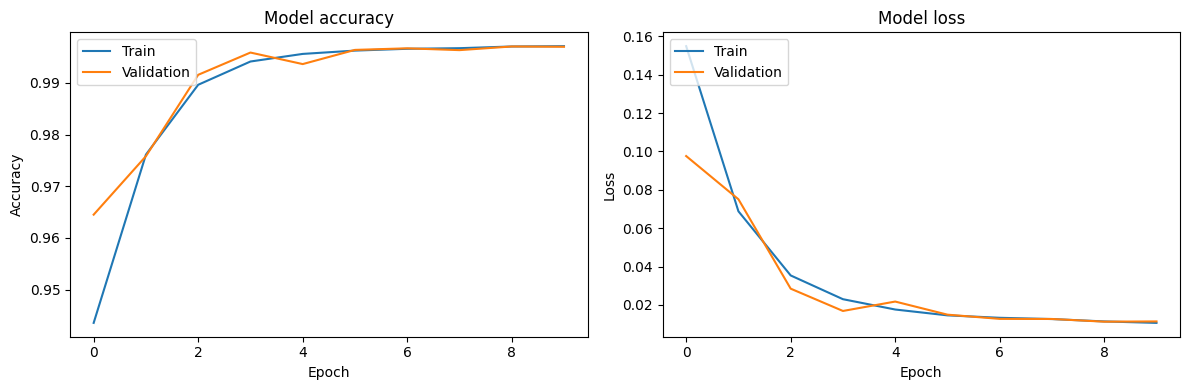

In [ ]:
import matplotlib.pyplot as plt

# Vẽ giá trị độ chính xác của quá trình huấn luyện và xác thực
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Vẽ giá trị mất mát của quá trình huấn luyện và xác thực
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## 4.3. Dự đoán các lớp cho tập kiểm tra và tạo báo cáo phân loại


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán các lớp cho tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ánh xạ tùy chỉnh từ số lớp sang tên lớp
custom_mapping = {
    'conficker': 0,
    'cryptolocker': 1,
    'zeus': 2,
    'pushdo': 3,
    'rovnix': 4,
    'tinba': 5,
    'matsnu': 6,
    'ramdo': 7
}

# Chuyển đổi các chỉ số lớp trở lại tên của chúng
target_names = [i for i in sorted(custom_mapping.keys())]

# Báo cáo phân loại
report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Precision, Recall, F1-Score trung bình theo micro và macro
micro_precision = precision_score(y_test, y_pred_classes, average='micro')
micro_recall = recall_score(y_test, y_pred_classes, average='micro')
micro_f1 = f1_score(y_test, y_pred_classes, average='micro')

macro_precision = precision_score(y_test, y_pred_classes, average='macro')
macro_recall = recall_score(y_test, y_pred_classes, average='macro')
macro_f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Micro average Precision: {micro_precision}')
print(f'Micro average Recall: {micro_recall}')
print(f'Micro average F1-Score: {micro_f1}')
print(f'Macro average Precision: {macro_precision}')
print(f'Macro average Recall: {macro_recall}')
print(f'Macro average F1-Score: {macro_f1}')


5000/5000 [==============================] - 29s 5ms/step
Classification Report:
              precision    recall  f1-score   support

   conficker       1.00      1.00      1.00     20088
cryptolocker       1.00      0.98      0.99     19986
      matsnu       1.00      1.00      1.00     20048
      pushdo       1.00      1.00      1.00     19824
       ramdo       1.00      1.00      1.00     19977
      rovnix       0.98      1.00      0.99     20042
       tinba       1.00      1.00      1.00     20180
        zeus       1.00      1.00      1.00     19855

    accuracy                           1.00    160000
   macro avg       1.00      1.00      1.00    160000
weighted avg       1.00      1.00      1.00    160000

Micro average Precision: 0.9969875
Micro average Recall: 0.9969875
Micro average F1-Score: 0.9969875
Macro average Precision: 0.9970396089338469
Macro average Recall: 0.99698795889685
Macro average F1-Score: 0.996990993324902
